# Imports

In [1]:
# basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
# mlflow
import mlflow
# great expectations
import great_expectations as gx
# termcolor
from termcolor import colored

In [2]:
x = RandomForestClassifier(random_state=420)

In [3]:
print(str(x).split("(")[0])

RandomForestClassifier


# MLFlow Experiment

FIRST: 
1. open ***mlflow ui*** via terminal

In [4]:
# Create a new experiment
experiment_name = "MLOps Project"

# create new experiment if not existing
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
# if experiment already exists, set experiment
except:
    mlflow.set_experiment(experiment_name)

In [5]:
# get experiment id
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Load Data

In [6]:
dataframe = pd.read_csv('Data/smoke_detection.csv', index_col=[0])

# Split Data

To simulate multiple datasets we're going to order the dataset bei the *UTC* column and split it into 3 equal parts

In [7]:
def split_dataframe(dataframe: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # order dataframe by month
    dataframe = dataframe.sort_values(by='UTC').reset_index(drop=True)
    
    # split dataframe into 3 equal sized datasets
    dataframe_1 = dataframe.iloc[:int(len(dataframe)/3)]
    dataframe_2 = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    dataframe_3 = dataframe.iloc[int(len(dataframe)/3)*2:]
    
    return dataframe_1, dataframe_2, dataframe_3

In [8]:
# pandas dataframes
df1, df2, df3 = split_dataframe(dataframe)

# EDA

In [9]:
print(f'Rows: {df1.shape[0]}\nColumns: {df1.shape[1]}')

Rows: 20876
Columns: 15


In [10]:
# first look at the data
df1.sample(5)

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
11965,1654739552,-7.972,53.96,171,400,13173,20103,939.683,1.08,1.12,7.41,1.156,0.026,6221,1
9084,1654736671,7.357,59.84,258,400,13149,19954,939.672,2.15,2.23,14.77,2.303,0.052,3340,1
15444,1654743031,-4.292,53.61,766,927,12663,19537,939.154,2.51,2.61,17.27,2.694,0.061,9700,1
8390,1654735977,15.875,53.01,74,400,13195,20103,939.647,1.18,1.23,8.12,1.266,0.029,2646,0
17819,1654745406,17.362,47.78,1015,574,12826,19472,939.001,1.93,2.01,13.29,2.073,0.047,12075,1


In [11]:
# descriptive statistics, data types and missing values
def dataset_infos(dataframe: pd.DataFrame = dataframe) -> pd.DataFrame:
    # descriptive statistics
    descriptives = dataframe.describe(include='all').T

    # data types column
    descriptives.insert(loc=0, column='dtype', value=dataframe.dtypes)
    
    # missing values
    missing = pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['nulls','empty strings'], axis=1)
    
    return pd.merge(descriptives, missing, left_index=True, right_index=True)

dataset_infos(df1)

,dtype,count,mean,std,min,25%,50%,75%,max,nulls,empty strings
UTC,int64,20876.0,1.654734e+09,12154.941397,1.654712e+09,1.654717e+09,1.654738e+09,1.654743e+09,1.654748e+09,0,0
Temperature[C],float64,20876.0,1.445650e+01,16.777181,-9.276000e+00,-4.094000e+00,1.693150e+01,2.637800e+01,5.993000e+01,0,0
Humidity[%],float64,20876.0,4.826455e+01,9.486005,1.074000e+01,4.700000e+01,5.015000e+01,5.336000e+01,7.520000e+01,0,0
TVOC[ppb],int64,20876.0,2.311279e+03,9539.882264,0.000000e+00,6.700000e+01,2.220000e+02,1.027000e+03,6.000000e+04,0,0
eCO2[ppm],int64,20876.0,6.927393e+02,1925.904927,4.000000e+02,4.000000e+02,4.000000e+02,5.090000e+02,3.918500e+04,0,0
Raw H2,int64,20876.0,1.295284e+04,318.702438,1.066800e+04,1.279400e+04,1.286800e+04,1.315100e+04,1.380300e+04,0,0
Raw Ethanol,int64,20876.0,1.990383e+04,683.249922,1.531700e+04,1.948400e+04,1.997600e+04,2.019125e+04,2.141000e+04,0,0
Pressure[hPa],float64,20876.0,9.387859e+02,1.004823,9.366240e+02,9.375470e+02,9.390970e+02,9.396340e+02,9.398610e+02,0,0
PM1.0,float64,20876.0,1.130871e+02,950.738240,0.000000e+00,7.600000e-01,1.820000e+00,2.160000e+00,1.334669e+04,0,0
PM2.5,float64,20876.0,1.936200e+02,1864.035040,0.000000e+00,8.000000e-01,1.890000e+00,2.240000e+00,4.126298e+04,0,0


In [12]:
# duplicate rows
print(f'Duplicated Rows: {df1.duplicated().sum()}')

Duplicated Rows: 0


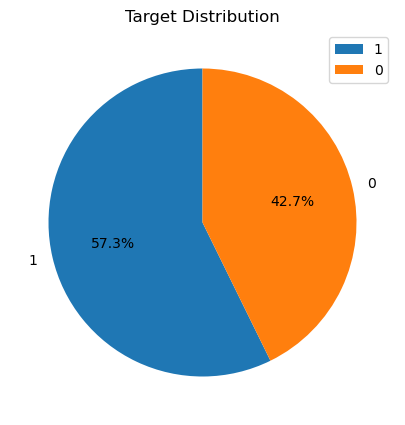

In [13]:
# plot target distribution (pie chart)
def plot_target_distribution(dataframe: pd.DataFrame = dataframe, target='Fire Alarm'):
    plt.figure(figsize=(10,5))
    plt.pie(dataframe[target].value_counts(), labels=dataframe[target].value_counts().index, autopct='%1.1f%%', startangle=90)
    plt.title('Target Distribution')
    plt.legend()
    plt.show()

plot_target_distribution(df1)

# Preprocessing

In [14]:
x, y = df1.drop(columns=['Fire Alarm']), df1['Fire Alarm']

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y,random_state=420)

In [16]:
def preprocessing(data: pd.DataFrame) -> pd.DataFrame:
  '''
  Preprocessing function
  Input: dataframe
  Output: transformed data
  '''

  run_name = "Preprocessing Pipeline"

  # preprocessing pipeline
  pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])
    
  # Search for preprocessing run
  run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{run_name}'")
  # get run id
  run_id = run.iloc[0].run_id if not run.empty else None

  # if preprocessing-run does not exist
  if run.empty:
    # fit & transform pipeline
    data_preprocessed = pipeline.fit_transform(data)
    # start run
    with mlflow.start_run(run_name=run_name) as run:
      # log pipeline
      mlflow.sklearn.log_model(pipeline, 'PreprocessingPipeline')
      # end run
      mlflow.end_run()
    
  # if preprocessing-run exists
  else:
    # load pipeline
    pipeline = mlflow.sklearn.load_model(f'runs:/{run_id}/PreprocessingPipeline')
    # transform data
    data_preprocessed = pipeline.transform(data)
    
  return data_preprocessed

In [17]:
# preprocess training data
xtrain_prepro = preprocessing(xtrain)

2023/05/25 13:18:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [18]:
# preprocess test data
xtest_prepro = preprocessing(xtest)

# Modelling

## Training Multiple Classifiers

In [19]:
# fit prediction model on train dataset
def classifier_comparison(
    xtrain: pd.DataFrame = xtrain_prepro,
    ytrain: pd.DataFrame = ytrain,
    xtest: pd.DataFrame = xtest_prepro,
    ytest: pd.DataFrame = ytest,
    clf: dict = {
        'Logistic Regression': LogisticRegression(random_state=420),
        'Decision Tree': DecisionTreeClassifier(random_state=420),
        'Random Forest': RandomForestClassifier(random_state=420)
        }
    ):

    run_name = "Classifier Comparison"

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # build plot
        fig, ax = plt.subplots(1, figsize=(10, 7))
        # iterate over classifiers
        for name, clf in clf.items():
            # fit classifier
            clf.fit(xtrain, ytrain)
            # plot roc curve
            RocCurveDisplay.from_estimator(clf, xtest, ytest, ax=ax, name=name)
        ax.set_title('Receiver Operating Characteristic (ROC)')
        ax.plot([0,1], [0,1], linestyle='--')
        # save plot
        plt.savefig('Plots/ROC Curves.png')
        # log plot
        mlflow.log_figure(fig, 'Plots/ROC Curves.png')
        # end run
        mlflow.end_run()
    
    return plt.show()


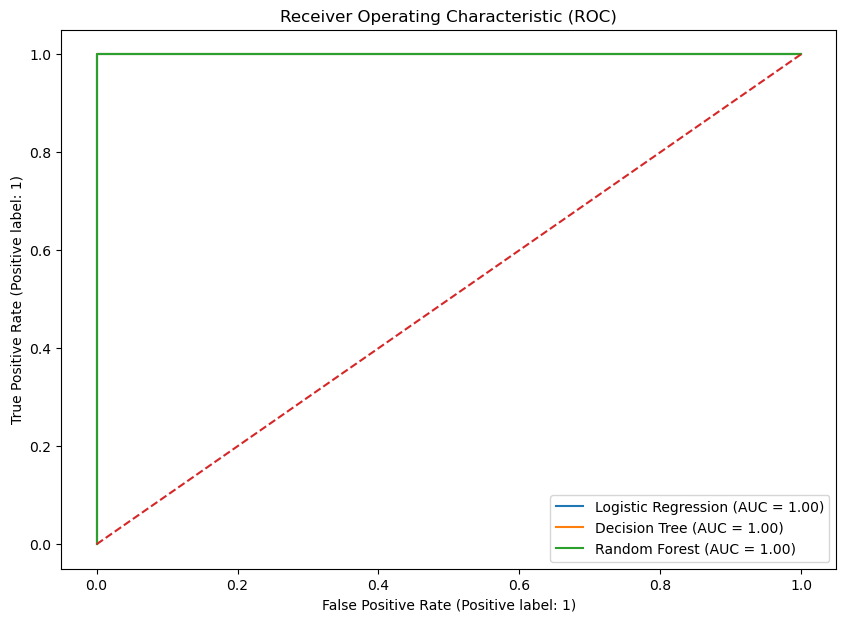

In [20]:
classifier_comparison(xtrain=xtrain_prepro, ytrain=ytrain, xtest=xtest_prepro, ytest=ytest)

## GridSearchCV

In [21]:
def grid_search(
    xtrain: pd.DataFrame = xtrain_prepro,
    ytrain: pd.DataFrame = ytrain,
    xtest: pd.DataFrame = xtest_prepro,
    ytest: pd.DataFrame = ytest,
    clf = RandomForestClassifier(random_state=420),
    param_grid: dict = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
        }
    ):

    # run name
    clf_name = str(clf).split("(")[0]
    run_name = f"Grid Search - {clf_name}"

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # initialize grid search
        grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
        # fit grid search
        grid.fit(xtrain, ytrain)
        # predict on test data
        ypred = grid.predict(xtest)
        # log model accuracy
        mlflow.log_metric(f'grid_search_accuracy', accuracy_score(ytest, ypred))
        # log model precision
        mlflow.log_metric(f'grid_search_precision', precision_score(ytest, ypred))
        # log model recall
        mlflow.log_metric(f'grid_search_recall', recall_score(ytest, ypred))
        # log model f1-score
        mlflow.log_metric(f'grid_search_f1_score', f1_score(ytest, ypred))
        # log model
        mlflow.sklearn.log_model(grid, f'GridSearch_{clf_name}')
        # log best parameters
        mlflow.log_param('best_params', grid.best_params_)
        # print classification report
        print(f'Classification Report:\n\n{classification_report(ytest, ypred)}\n\n')
        # end run
        mlflow.end_run()

In [22]:
# logistic regression grid_params
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }

grid_search(xtrain=xtrain_prepro, ytrain=ytrain, xtest=xtest_prepro, ytest=ytest, clf=LogisticRegression(random_state=420), param_grid=grid_params)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   macro avg       1.00      1.00      1.00      4176
weighted avg       1.00      1.00      1.00      4176





In [23]:
# decision tree grid_params
grid_params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
    }

grid_search(xtrain=xtrain_prepro, ytrain=ytrain, xtest=xtest_prepro, ytest=ytest, clf=DecisionTreeClassifier(random_state=420), param_grid=grid_params)

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   macro avg       1.00      1.00      1.00      4176
weighted avg       1.00      1.00      1.00      4176





In [24]:
grid_search(xtrain=xtrain_prepro, ytrain=ytrain, xtest=xtest_prepro, ytest=ytest, clf=RandomForestClassifier(random_state=420))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1784
           1       1.00      1.00      1.00      2392

    accuracy                           1.00      4176
   macro avg       1.00      1.00      1.00      4176
weighted avg       1.00      1.00      1.00      4176





## Train Model with GridSearchCV-Parameters and all Training Data

In [25]:
def training(x: pd.DataFrame, y: pd.DataFrame, clf = RandomForestClassifier(random_state=420)):
    
    # run name
    clf_name = str(clf).split("(")[0]
    run_name = f"Trained Model - {clf_name}"

    # check if grid search run exists
    model_grid_search = f"Grid Search - {clf_name}"

    # Search for grid search run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{model_grid_search}'")
    
    # if grid search run does not exist
    if run.empty:
        print(f'No grid search run found for {clf_name}...')
        print('Model logged with default parameters...')
        # initialize default model
        model = clf
    # if grid search run exists
    else:
        print(f'Grid search run found for {clf_name}...')
        print('Model logged with optimal parameters...')
    # get grid search parameters
        grid_params = ast.literal_eval(run.iloc[0]['params.best_params'])
        # initialize model
        model = clf.set_params(**grid_params)

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # fit model
        model.fit(x, y)
        # log model
        mlflow.sklearn.log_model(model, 'model')
        # end run
        mlflow.end_run()

In [26]:
# combine training and test data
x = np.concatenate((xtrain_prepro, xtest_prepro), axis=0)
y = np.concatenate((ytrain, ytest), axis=0)

In [27]:
training(x, y, clf=LogisticRegression(random_state=420))

Grid search run found for LogisticRegression...
Model logged with optimal parameters...


In [28]:
training(x, y, clf=DecisionTreeClassifier(random_state=420))

Grid search run found for DecisionTreeClassifier...
Model logged with optimal parameters...


In [29]:
training(x, y, clf=RandomForestClassifier(random_state=420))

Grid search run found for RandomForestClassifier...
Model logged with optimal parameters...


## Prediction

In [30]:
def predict_new_data(x, y, clf = RandomForestClassifier(random_state=420)):

    # get dataframe name
    dataframe_name = [i for i in globals() if globals()[i] is x][0]

    # run name
    clf_name = str(clf).split("(")[0]
    run_name = f"{clf_name} Prediction - {dataframe_name}"

    # check if classifier already got trained
    trained_model_search = f"Trained Model - {clf_name}"

    # search run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{trained_model_search}'")
    
    # if no trained model found
    if run.empty:
        print(f'No trained model found for {clf_name}...')
    # if trained model found
    else:
        print(f'Trained model found for {clf_name}...')
        # get run id
        run_id = run.iloc[0].run_id if not run.empty else None
        # load model (optimal)
        model = mlflow.sklearn.load_model(f'runs:/{run_id}/model')

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # predict on new data
        ypred = model.predict(x)
        # log model accuracy
        mlflow.log_metric(f'{dataframe_name}_accuracy', accuracy_score(y, ypred))
        # log model precision
        mlflow.log_metric(f'{dataframe_name}_precision', precision_score(y, ypred))
        # log model recall
        mlflow.log_metric(f'{dataframe_name}_recall', recall_score(y, ypred))
        # log model f1-score
        mlflow.log_metric(f'{dataframe_name}_f1_score', f1_score(y, ypred))
        # log parameters
        mlflow.log_param(f'{dataframe_name}_params', model.get_params())
        # log model
        mlflow.sklearn.log_model(model, f'{dataframe_name}_model')
        # print classification report
        print(f'Classification Report:\n\n{classification_report(y, ypred)}\n\n')
        # end run
        mlflow.end_run()

# Great Expectations

In [31]:
def great_expectations(check_dataframe, initial_dataframe=df1):

    initial_df = gx.dataset.PandasDataset(initial_dataframe)
    check_df = gx.dataset.PandasDataset(check_dataframe)
    
    # get column names from initial dataframe
    gx_columns = initial_df.get_table_columns()
    # get dtypes from initial dataframe
    gx_dtypes = initial_df.dtypes.apply(lambda x: str(x)).to_dict()

    # check if column are the same in all dataframes
    column_check = check_df.expect_table_columns_to_match_ordered_list(column_list=gx_columns)
    if column_check['success']:
        print('Columns Check: ', colored('OK', 'green'))
    else:
        print('Columns Check: ', colored('Failed', 'red'))

    # check if dtypes are the same in all dataframes
    check_set = set()
    for col, data_type in gx_dtypes.items():
        datatype_check = check_df.expect_column_values_to_be_of_type(column=col, type_=data_type)
        check_set.add(datatype_check['success'])
    if all(check_set) == True:
        print('Datatype Check: ', colored('OK', 'green'))
    else:
        print('Datatype Check: ', colored('Failed', 'red'))

    # check if dataframe has missing values
    check_set = set()
    for col in gx_columns:
        missing_values_check = check_df.expect_column_values_to_not_be_null(column=col)
        check_set.add(missing_values_check['success'])
    if all(check_set) == True:
        print('Missing Values Check: ', colored('OK', 'green'))
    else:
        print('Missing Values Check: ', colored('Failed', 'red'))

    # check if dataframe has duplicates
    duplicates_check = check_df.expect_table_row_count_to_be_between(min_value=check_df.shape[0], max_value=check_df.shape[0])
    if duplicates_check['success']:
        print('Duplicates Check: ', colored('OK', 'green'))
    else:
        print('Duplicates Check: ', colored('Failed', 'red'))

    # check if dataframe distribution is the same as in initial dataframe
    check_set = set()
    for col in gx_columns:
        distribution_check = check_df.expect_column_kl_divergence_to_be_less_than(column=col, partition_object={'values': initial_df[col].value_counts().index.tolist(), 'weights': initial_df[col].value_counts(normalize=True).tolist()}, threshold=0.6)
        check_set.add(distribution_check['success'])
    if all(check_set) == True:
        print('Distribution Check: ', colored('OK', 'green'))
    else:
        print('Distribution Check: ', colored('Failed', 'red'))

    # check if dataframe has outliers
    check_set = set()
    for col in gx_columns:
        outliers_check = check_df.expect_column_values_to_be_between(column=col, min_value=initial_df[col].min(), max_value=initial_df[col].max())
        check_set.add(outliers_check['success'])
    if all(check_set) == True:
        print('Outlier Check: ', colored('OK', 'green'))
    else:
        print('Outlier Check: ', colored('Failed', 'red'))

# Dataset 2

In [32]:
great_expectations(check_dataframe=df2, initial_dataframe=df1)

Columns Check:  OK
Datatype Check:  OK
Missing Values Check:  OK
Duplicates Check:  OK
Distribution Check:  Failed
Outlier Check:  Failed


In [33]:
df2_prepro, df2_y = preprocessing(df2.drop(columns=['Fire Alarm'])), df2['Fire Alarm']

In [34]:
predict_new_data(df2_prepro, df2_y, clf=LogisticRegression(random_state=420))

Trained model found for LogisticRegression...
Classification Report:

              precision    recall  f1-score   support

           0       0.39      1.00      0.56      3178
           1       1.00      0.71      0.83     17698

    accuracy                           0.76     20876
   macro avg       0.69      0.86      0.69     20876
weighted avg       0.91      0.76      0.79     20876





In [35]:
predict_new_data(df2_prepro, df2_y, clf=DecisionTreeClassifier(random_state=420))

Trained model found for DecisionTreeClassifier...
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3178
           1       0.85      1.00      0.92     17698

    accuracy                           0.85     20876
   macro avg       0.42      0.50      0.46     20876
weighted avg       0.72      0.85      0.78     20876





In [36]:
predict_new_data(df2_prepro, df2_y, clf=RandomForestClassifier(random_state=420))

Trained model found for RandomForestClassifier...
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      3178
           1       0.85      1.00      0.92     17698

    accuracy                           0.85     20876
   macro avg       0.93      0.52      0.50     20876
weighted avg       0.88      0.85      0.79     20876





# Dataset 3

In [37]:
great_expectations(check_dataframe=df3, initial_dataframe=df1)

Columns Check:  OK
Datatype Check:  OK
Missing Values Check:  OK
Duplicates Check:  OK
Distribution Check:  Failed
Outlier Check:  Failed


In [38]:
df3_prepro, df3_y = preprocessing(df3.drop(columns=['Fire Alarm'])), df3['Fire Alarm']

In [39]:
predict_new_data(df3_prepro, df3_y, clf=LogisticRegression(random_state=420))

Trained model found for LogisticRegression...
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      5775
           1       0.90      0.88      0.89     15103

    accuracy                           0.84     20878
   macro avg       0.80      0.82      0.81     20878
weighted avg       0.85      0.84      0.85     20878





In [40]:
predict_new_data(df3_prepro, df3_y, clf=DecisionTreeClassifier(random_state=420))

Trained model found for DecisionTreeClassifier...
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5775
           1       0.72      1.00      0.84     15103

    accuracy                           0.72     20878
   macro avg       0.36      0.50      0.42     20878
weighted avg       0.52      0.72      0.61     20878





In [41]:
predict_new_data(df3_prepro, df3_y, clf=RandomForestClassifier(random_state=420))

Trained model found for RandomForestClassifier...
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.13      0.19      5775
           1       0.73      0.93      0.82     15103

    accuracy                           0.70     20878
   macro avg       0.56      0.53      0.51     20878
weighted avg       0.64      0.70      0.65     20878





# retrain

In [42]:
# combine xtrain_prepro, xtest_prepro and df2_prepro
# x = np.concatenate((xtrain_prepro, xtest_prepro, df2_prepro), axis=0)
# combine ytrain, ytest and df2_y
# y = np.concatenate((ytrain, ytest, df2_y), axis=0)

In [43]:
# predict_new_data(df3_prepro, df3_y)